# Homework 4: Simple DMRG
+ Spring 2018: Advanced Statistical Mechanics
+ Peijun Zhu <pez33@pitt.edu>

The goal of this homework is to construct a simple Density Matrix Renormalization Group (DMRG) code in the framework of Matrix Product States (MPS).
### Step 1: Construct a random MPS

Execute the code below to construct a MPS for a spin-$1/2$ chain of length $n=5$ with bond dimension $\chi =3$;
indices:

+ `MPS[[i,σ,k,l]]`
+ `i` -- site
+ `σ` -- spin
+ `k` -- internal bond to the left
+ `l` -- internal bond to the right

In [1]:
%pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy.random import uniform
import itertools as it
from functools import reduce

In [3]:
# This function returns a random, but valid, MPS state, that is tapered
# on the edges
def mkMPSt(chi, dd, n):
    MPS = []
    for i in range(n):
        s1 = min(2**i, 2**(n-i), chi)
        s2 = min(2**(i+1), 2**(n-(i+1)), chi)
        MPS.append(uniform(size=(dd, s1, s2)))
    return MPS

chi = 3
n = 5
dd = 2

MPS = mkMPSt(chi, dd, n)
[i.shape for i in MPS]

[(2, 1, 2), (2, 2, 3), (2, 3, 3), (2, 3, 2), (2, 2, 1)]

### Step 2: MPS -> Exact Form

write a function that evaluates the coefficient of the configuration config. Use your function to com-
pute the coefficient of each basis element thus converting the MPS you obtained in the first step into
exact form.

In [4]:
def psiMPSEval(MPS, config):
    '''Computes the coefficient of the configuration given an MPS state'''
    Matrix_chain =  [T[config[i]] for i, T in enumerate(MPS)]
    return reduce(matmul, Matrix_chain).reshape([])

In [5]:
basis = list(it.product(*[[0,1]]*5))

In [6]:
def MPS2psi(MPS):
    return np.array([psiMPSEval(MPS, config) for config in basis])

In [9]:
psi = MPS2psi(MPS)

In [10]:
psi

array([1.1004894 , 0.5079112 , 1.12414051, 0.51890544, 1.55203514,
       0.70641392, 0.75867552, 0.34126815, 1.04942971, 0.47735473,
       0.96067716, 0.44989764, 0.79945073, 0.36261955, 0.31609265,
       0.14098227, 2.6905812 , 1.24194312, 2.6222083 , 1.20680101,
       3.12811191, 1.4270438 , 1.58040245, 0.70846159, 2.55095843,
       1.1815708 , 2.36567624, 1.07980842, 2.38079797, 1.09213898,
       1.32754072, 0.59199802])

### Step 3: Normalization:
1. write a function that computes the inner product of two MPSs
2. write a function that multiplies your MPS by a scalar
3. normalize your MPS
4. verify that your MPS is really normalized by converting it to exact form and checking normalization

In [11]:
def InnerProduct(MPS1, MPS2):
    '''computes the inner product 〈ψ1|ψ2〉 of two MPS wave functions.'''
    M = [np.einsum('ijk, ilm->jlkm', T1, T2.conj()) for T1, T2 in zip(MPS1, MPS2)]
    M = [m.reshape(prod(m.shape[:2]), -1) for m in M]
    return reduce(matmul, M).item()

def ScalarMultiply(MPS1, scalar):
    '''computes the scaler product scalar |ψ〉 of a scalar and an MPS wave function.'''
    L = len(MPS1)
    c = scalar**(1/L)
    return [c*T for T in MPS1]

ScalarProduct = InnerProduct
MPSn = ScalarMultiply(MPS, 1/sqrt(ScalarProduct(MPS, MPS)))

In [12]:
ScalarProduct(MPS, MPS)

65.52159940324103

In [13]:
ScalarProduct(MPSn, MPSn)

0.9999999999999998

### Step 4: Construct the Hamiltonian:

1. Write a function that constructs the MPO representation of the Hamiltonian

\begin{equation}
H=J\sum_{i=1}^{n-1}\sigma_i^z\sigma_{i+1}^z+h\sum_{i=1}^n\sigma_i^x
\end{equation}
2. Write a function that calculates the expectation value $\langle\psi_1|H|\psi_2\rangle$
3. Compute the expectation value 〈MPSn | H | MPSn〉 using the state MPSn from step 3 and the Hamiltonian with $J_i = 1$ and $h_i = 1.2$. Verify your answer using exact representation of the Hamiltonian and the state.

In [14]:
# Pauli Matrices
sigma = [eye(2), array([[0,1], [1, 0]]), 'sigma_y', diag([1, -1])]
# Zero Matrix
null = zeros([2,2])

def mkHamiltonianMatrix(J, h):
    '''Construct MPO representation'''
    mpo = np.array([
        [sigma[0], null, null],
        [J*sigma[3], null, null],
        [h*sigma[1], sigma[3], sigma[0]]
    ])
    return mpo

def ComputeEnergyLeft(MPS1, MPO, MPS2):
    '''evaluate 〈MPS1 | MPO | MPS2〉 using starting from Left'''
    M = [np.einsum('ijk, lmih, hno->jlnkmo', T1, MPO, T2)
         for T1, T2 in zip(MPS1, MPS2)]
    M[0] = M[0][:, -1:]
    M[-1] = M[-1][..., :1, :]
    M = [m.reshape(prod(m.shape[:3]), -1) for m in M]
    return reduce(matmul, M).item()

In [15]:
MPO = mkHamiltonianMatrix(1, 1.2)
ComputeEnergyLeft(MPSn, MPO, MPSn)

4.951336555305712

#### Exact Hamiltonian

In [16]:
def nearest(n, *ops, coef=1):
    '''Generate k nearest Hamiltonian term
    $$\sum_{i=0}^{n-k} \bigotimes_{j=0}^{k-1} \Omega^k_{i+j}$$
    k is number of operators

    Args:
    n       length of chain
    ops     Operator list
    coef    Coefficients of term at some site
    Examples:
    n sites $\sum_i X_i$ can be generated by nearest(6, X)
    n sites $\sum_i X_iY_{i+1}$ can be generated by nearest(6, X, Y)
    '''
    eye_n = np.eye(*ops[0].shape)
    coef *= np.ones(n)

    def _H_i(k):
        l = [eye_n for i in range(n)]
        for i, op in enumerate(ops):
            l[k + i] = op
        return reduce(np.kron, l)
    return sum(coef[k] * _H_i(k) for k in range(n + 1 - len(ops)))

def TransverseField(n, J=1, h=1.2):
    '''Transverse field Ising model'''

    H = np.zeros([2**n, 2**n])
    H += nearest(n, sigma[3], sigma[3], coef=J)
    H += nearest(n, sigma[1], coef=h)

    return H

In [17]:
H = TransverseField(5, 1, 1.2)
psi = MPS2psi(MPSn)
psi@H@psi

4.951336555305716

### Step 5: Implement Sweeps (without using canonical form)

Below is a function that computes the overlap matrix on site i

1. Write a function that computes the effective Hamiltonian on site i (feel free to use my function as a
starting point)
2. Write a function that given an MPS, an MPO, and the site index i constructs the generalized eigen-value problem and returns the MPS with an updated set of matrices on site i.
3. Write a function that sweeps over the sites of the chain. For each site i:
    + update the matrices on site i of the MPS using your function from (2)
    + normalize the MPS
    + compute and save the expectation value of the energy

For the remaining two parts we shall consider three sets of parameters for the Hamiltonian:
+ J=1 h=0
+ J=0 h=1
+ J=1 h=1


4 .  What is the expectation value of the energy for the ground state for the three cases? What are the
ground state wave functions.

5 . What do you expect to happen to the expectation value of the energy as you sweep? Plot the expectation value of the energy as you sweep (several times) and make sure the results make sense. Does your
final answer match your expectations from (4)

In [18]:
def computeHeff(MPS, MPO, i):
    '''Effective Hamiltonian'''
    L = np.zeros([1, MPO.shape[0], 1])
    R = np.zeros([1, MPO.shape[1], 1])
    L[0,-1,0] = 1
    R[0,0,0] = 1
    for j in range(i):
        L = np.einsum('ijk, lin, jolm, mkp->nop', L, MPS[j], MPO, MPS[j])
    for j in range(n-1, i, -1):
        R = np.einsum('ijk, lni, ojlm, mpk->nop', R, MPS[j], MPO, MPS[j])
    op = np.einsum('ijk, jolm, nop->linmkp', L, MPO, R)
    return op.reshape(prod(op.shape[:3]), -1)

def computeOverlap(MPS, i):
    '''Just Use Identity MPO'''
    MPO = np.array([[np.eye(2)]])
    return computeHeff(MPS, MPO, i)

In [19]:
H0 = computeOverlap(MPSn, 2)
phi = MPSn[2].flatten()

In [20]:
phi@H0@phi

0.9999999999999997

In [21]:
MPO = mkHamiltonianMatrix(1, 1.2)
def updateMPS(MPS, MPO, i):
    '''Update MPS at site i, return value is energy'''
    G = computeOverlap(MPS, i)
    H = computeHeff(MPS, MPO, i)
    phi = MPS[i].flatten()
    U, S, V = svd(G)
    cond = S > 1e-8
    iu = V[cond]/np.sqrt(S[cond, np.newaxis])
    H2 = iu@H@iu.T.conj()
    w, v = eigh(H2)
    phi = iu.T.conj()@v[:, 0]
    MPS[i] = phi.reshape(MPS[i].shape)
    return w[0]

In [22]:
def sweeps(MPS, MPO, n=5):
    '''Sweep and return saved energy'''
    l=[]
    for k in range(n):
        for i in range(len(MPS)):
            E = updateMPS(MPS, MPO, i)
            l.append(E)
    return array(l)

(4).
+ For $J=1, g=0$, ground wave function is $|01010\rangle$ or $|10101\rangle$
+ For $J=0, g=1$, ground wave function is $|-----\rangle$, where $|-\rangle=|0\rangle-|1\rangle$
+ For $J=1, g=1$, it is at critical point. Our result of DMRG gives:

(5).During sweeping, energy should decrease until some point.

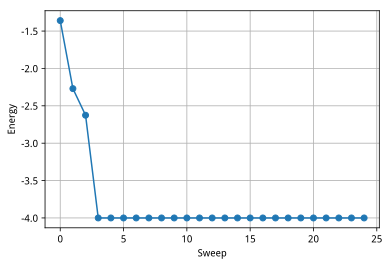

In [23]:
MPO = mkHamiltonianMatrix(1, 0)
mps = MPSn.copy()
plot(sweeps(mps, MPO, 5), 'o-');
ylabel('Energy')
grid()
xlabel('Sweep');

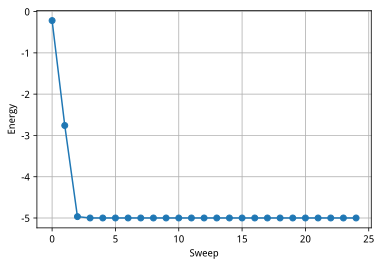

In [24]:
MPO = mkHamiltonianMatrix(0, 1)
mps = MPSn.copy()
plot(sweeps(mps, MPO, 5), 'o-');
grid()
ylabel('Energy')
xlabel('Sweep');

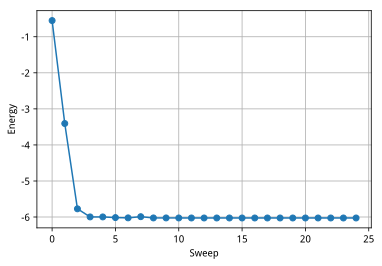

In [25]:
MPO = mkHamiltonianMatrix(1, 1)
mps = MPSn.copy()
plot(sweeps(mps, MPO, 5), 'o-');
grid()
ylabel('Energy')
xlabel('Sweep');

In [26]:
MPS2psi(mps).reshape(*[2]*5)

array([[[[[-0.05821531,  0.08584997],
          [ 0.14640426, -0.0812536 ]],

         [[ 0.1217441 , -0.22874038],
          [-0.11132921,  0.08233031]]],


        [[[ 0.14646798, -0.19012455],
          [-0.43598593,  0.22807721]],

         [[-0.10963729,  0.19068223],
          [ 0.13873223, -0.08713593]]]],



       [[[[ 0.08620086, -0.13939678],
          [-0.18935232,  0.11209611]],

         [[-0.22962903,  0.43551062],
          [ 0.18994496, -0.14551652]]],


        [[[-0.08102137,  0.11081232],
          [ 0.22876611, -0.12251642]],

         [[ 0.08145655, -0.14630979],
          [-0.08648575,  0.05762868]]]]])